In [1]:
import sys
sys.path.append('/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic')
sys.path.append('/home/g201381710/.local/lib/python3.10/site-packages')
sys.path.append('/home/g201381710/anaconda3/envs/dl4/lib/python3.10/site-packages')

sys.path

['/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic/dotless_arabic/analysis/notebooks',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/g201381710/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/g201381710/.ipython',
 '/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic',
 '/home/g201381710/.local/lib/python3.10/site-packages',
 '/home/g201381710/anaconda3/envs/dl4/lib/python3.10/site-packages']

In [2]:

from collections import Counter
from functools import lru_cache

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress

from dotless_arabic.processing import process,undot

from dotless_arabic.datasets.news.collect import collect_raw_dataset as collect_raw_news_dataset
from dotless_arabic.datasets.quran.collect import collect_raw_dataset as collect_raw_quran_dataset
from dotless_arabic.datasets.poems.collect import collect_raw_dataset as collect_raw_poems_dataset
from dotless_arabic.datasets.wikipedia.collect import collect_raw_dataset as collect_raw_wikipedia_dataset
from dotless_arabic.datasets.sanadset_hadeeth.collect import collect_raw_dataset as collect_raw_hadeeth_dataset
from dotless_arabic.datasets.aggregated.collect import collect_raw_dataset as collect_raw_aggregated_dataset

# functions

In [3]:
@lru_cache()
def characters_counter(dataset):
  return Counter(character for item in tqdm(dataset) for character in list(item))

@lru_cache()
def words_counter(dataset):
  return Counter(word for item in tqdm(dataset) for word in item.split())

In [4]:
@lru_cache()
def undot_dataset(dataset):
    return list(map(undot, tqdm(dataset)))

@lru_cache()
def process_dataset(dataset):
    return list(map(process, tqdm(dataset)))

In [5]:
def get_zipf_constants(dataset):
    counter = words_counter(tuple(dataset))
    heighest_frequency = counter.most_common(1)[0][1]
    X = np.log(heighest_frequency) * np.log((np.arange(len(counter)) + 1))
    Y = np.log(np.array(list(counter.values())))
    slope, intercept, *_ = linregress(X, Y)
    return np.exp(slope), np.exp(intercept)


In [6]:
poems = list()
for poem in tqdm(collect_raw_poems_dataset()['poem verses']):
    poems.extend(poem)
poems = list(set(poems))

Using custom data configuration MagedSaeed--ashaar-719bb58a76ea0092
Found cached dataset parquet (/home/g201381710/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/254630 [00:00<?, ?it/s]

In [26]:
datasets = [
    process_dataset(dataset=tuple(collect_raw_quran_dataset())),
    process_dataset(dataset=tuple(collect_raw_hadeeth_dataset())),
    process_dataset(dataset=tuple(poems)),
    process_dataset(dataset=tuple(collect_raw_wikipedia_dataset())),
    process_dataset(dataset=tuple(collect_raw_news_dataset())),
    process_dataset(dataset=tuple(collect_raw_aggregated_dataset())),
]
datasets_names = [
    'quran',
    'sanadset hadeeth',
    'poems',
    'wikipedia',
    'news',
    'aggregated',
]

####################################################################################################
Original Number of Samples:
650,986
####################################################################################################
####################################################################################################
Number of Samples after dropping duplicates:
637,565
####################################################################################################


Using custom data configuration MagedSaeed--ashaar-719bb58a76ea0092
Found cached dataset parquet (/home/g201381710/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/254630 [00:00<?, ?it/s]

####################################################################################################
Original Number of Samples:
650,986
####################################################################################################
####################################################################################################
Number of Samples after dropping duplicates:
637,565
####################################################################################################


In [38]:
def plot_zipf(datasets=datasets, datasets_names=datasets_names, figsize=(20, 15), top_words=10_000_000):
    # https://github.com/MagedSaeed/zipfs_law
    def _plot(counter, name, axis, log):
        frequencies = [
            item[1]
            for item in sorted(counter.items(), key=lambda item: item[1], reverse=True)
        ][:top_words]
        ranks = [
            item + 1
            for item in range(
                len(sorted(counter.items(), key=lambda item: item[1], reverse=True))
            )
        ][:top_words]
        axis.plot(ranks, frequencies, label=name)

        if log:
            axis.set_xscale("log")
            axis.set_yscale("log")
            # axis.set_ylim(bottom=10**0)
            # axis.set_ylim(top=10**7.5)

        # add axis labels, title, and legend
        plt.xlabel('Rank', fontsize=15)
        plt.ylabel('Frequency', fontsize=15)
        title = "Frequency vs Rank for Words in a Text"
        if log:
            title = "Logorithmic " + title
        # axis.set_title(title)
        axis.legend(loc="upper right",fontsize = '15')

    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    for dataset,dataset_name in zip(datasets,datasets_names):
        
        undotted_dataset = undot_dataset(dataset=tuple(dataset))
        dotted_counter = words_counter(dataset=tuple(dataset))
        undotted_counter = words_counter(dataset=tuple(undotted_dataset))
        highest_frequency_dotted = dotted_counter.most_common(1)[0][1]
        alpha_dotted, c_dotted = get_zipf_constants(dataset)
        alpha_undotted, c_dotted = get_zipf_constants(undotted_dataset)
        print('-'*100)
        print('alpha dotted for',dataset_name,' is:',alpha_dotted)
        print('alpha undotted for',dataset_name,' is:',alpha_undotted)
        print('-'*100)
        
        # logarithmic fit
        _plot(
            counter=dotted_counter,
            name=dataset_name+f" dataset (α={alpha_dotted:.4f})",
            axis=axis,
            log=True,
        )
        _plot(
            counter=undotted_counter,
            name="undotted " + dataset_name + f" dataset (α={alpha_undotted:.4f})",
            axis=axis,
            log=True,
        )
        _plot(
            counter={
                # rank:heighest_frequency*(1/rank) # use the estimated zipf's values
                # rank:  freqs_sum / c * rank **(-alpha) # use the estimated zipf's values
                rank: highest_frequency_dotted / (rank**alpha_dotted)
                for rank, frequency in enumerate(
                    sorted(
                        dotted_counter.values(),
                        reverse=True,
                    ),
                    start=1,
                )
            },
            name=f"zipfian regression fit for dotted {dataset_name} dataset",
            axis=axis,
            log=True,
        )
    # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib
    # https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
    plt.rc('font',size=12)

----------------------------------------------------------------------------------------------------
alpha dotted for quran  is: 0.933618297812913
alpha undotted for quran  is: 0.9314151505840239
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
alpha dotted for sanadset hadeeth  is: 0.9142644529663847
alpha undotted for sanadset hadeeth  is: 0.9092189636995011
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
alpha dotted for wikipedia  is: 0.9249418845338754
alpha undotted for wikipedia  is: 0.9203060998235564
----------------------------------------------------------------------------------------------------


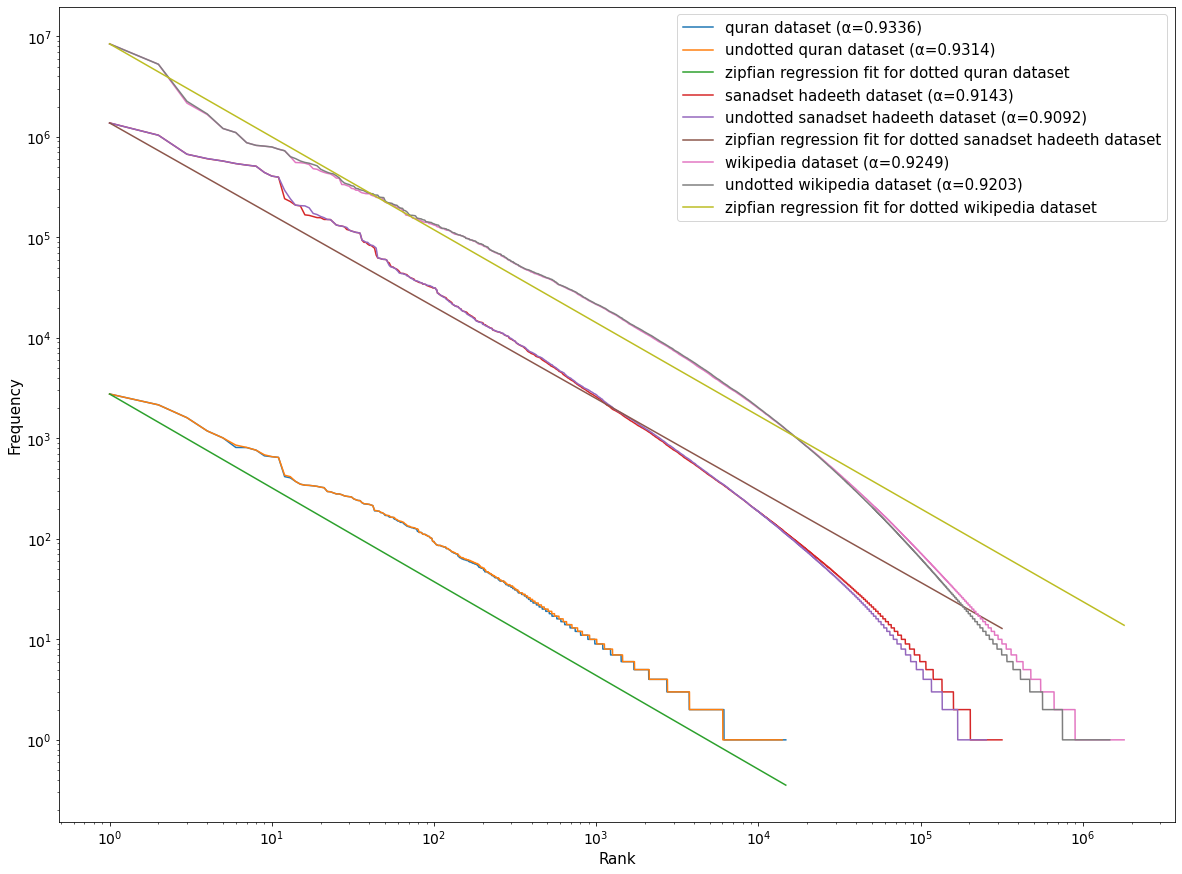

In [39]:
plot_zipf(
    datasets=[datasets[0],datasets[1],datasets[3]],
    datasets_names=[datasets_names[0],datasets_names[1],datasets_names[3]],
)

----------------------------------------------------------------------------------------------------
alpha dotted for poems  is: 0.9229694405662755
alpha undotted for poems  is: 0.9151153400966483
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
alpha dotted for news  is: 0.9077269938370282
alpha undotted for news  is: 0.9027371100795933
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
alpha dotted for aggregated  is: 0.9440967490610931
alpha undotted for aggregated  is: 0.9368909964824872
----------------------------------------------------------------------------------------------------


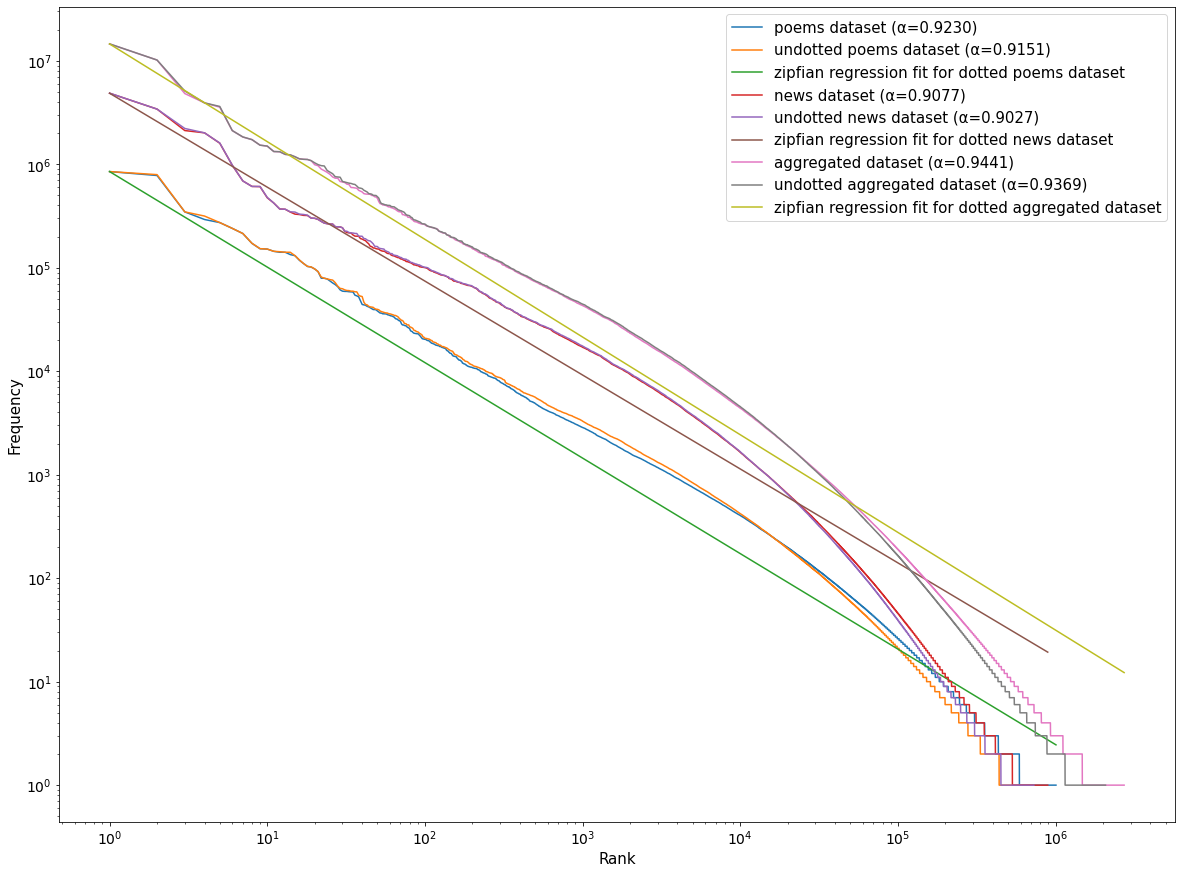

In [40]:
plot_zipf(
    datasets=[datasets[2],datasets[4],datasets[5]],
    datasets_names=[datasets_names[2],datasets_names[4],datasets_names[5]],
)